In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
from glob import glob

In [3]:
dfs = []
for fn in glob('learningsys-2018-gpu-mux/**/*.pq', recursive=True):
    df = pd.read_parquet(fn)
    _, _, approach, model, proc, i  = fn.split("/")
    df['approach'] = approach
    df['model'] = model
    df['n_procs'] = int(proc)
    df['proc'] = int(i.split('.')[0])
    dfs.append(df)

In [4]:
df = pd.concat(dfs)

In [5]:
df = df[df['approach'].isin(['mps', 'mps-even', 'mps-even-times-2', 'batch'])]

In [6]:
anomoly = df.groupby(
    ['approach', 'model', 'n_procs', 'proc']
)[['duration_ms']].mean().reset_index().groupby(
    ['approach', 'model', 'n_procs'])[['duration_ms']].apply(lambda s: s.max() - s.min()).reset_index()

In [7]:
anomoly = anomoly[anomoly['duration_ms']>0.1]

In [8]:
anomoly

,approach,model,n_procs,duration_ms
19,mps,mobilenet,5,2.095146
21,mps,res152,2,1.109918
22,mps,res152,3,1.714324
23,mps,res152,4,2.455351
24,mps,res152,5,6.571606
27,mps,res50,3,0.161983
28,mps,res50,4,0.664032
29,mps,res50,5,1.578369
32,mps-even,mobilenet,3,0.246984
33,mps-even,mobilenet,4,0.127765


In [9]:
sns.set(style='whitegrid', palette='muted', font='serif')

In [23]:
def plot_anomoly(approach):
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    sns.pointplot(x='n_procs', y='duration_ms', hue='model', data=anomoly[anomoly['approach'] == approach])
    plt.axhline(0.1, label='0.1 lower bound')
    plt.legend()
    plt.xlabel('Number of Replicas')
    plt.ylabel(r'Mean Latency $\Delta$ (ms)')
    plt.title('Max difference between processes')

    plt.subplot(1,2,2)
    res152_5_procs = df[(df['model'] == 'res152') & (df['n_procs'] == 5) & (df['approach'] == approach)][['duration_ms', 'proc', 'query_id']]
    sns.lineplot(x='query_id', y='duration_ms', hue='proc', data=res152_5_procs)
    plt.xlabel('Query IDs')
    plt.ylabel('Latency (ms)')
    plt.title(f'Example: Res152, {approach}, 5 Processes')

    plt.savefig(f'anomoly-{approach}.png', dpi=300)

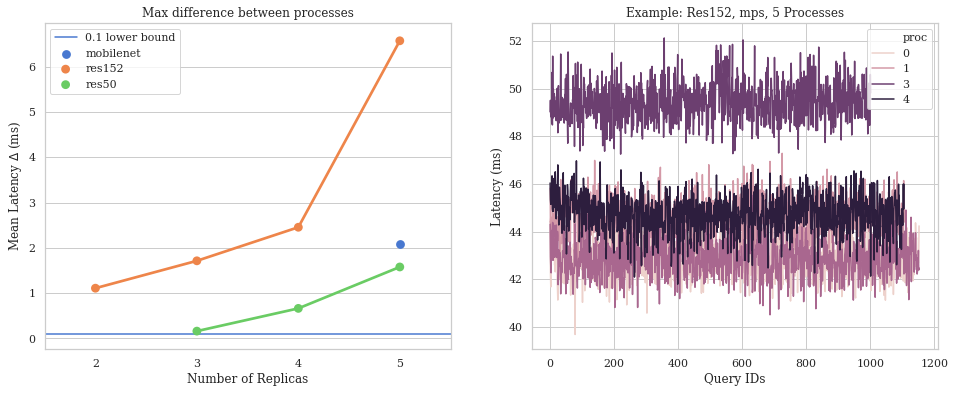

In [24]:
plot_anomoly('mps')

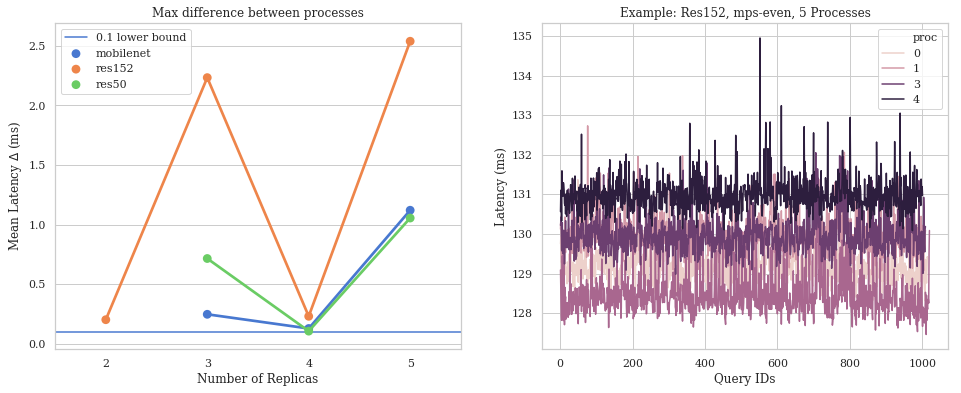

In [25]:
plot_anomoly('mps-even')

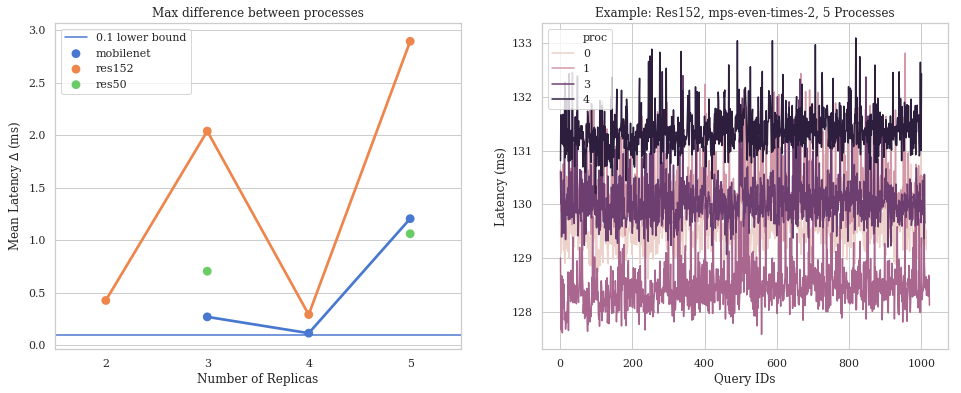

In [26]:
plot_anomoly('mps-even-times-2')